## Skrypt do trenowania detektora maski na twarzy

### Pobranie datasetu prosto z Kaggle
#### Należy zalogować się do Kaggla i postępować zgodnie z instrukcją: https://www.analyticsvidhya.com/blog/2021/04/how-to-download-kaggle-datasets-using-jupyter-notebook/

In [4]:
import opendatasets as od
od.download("https://www.kaggle.com/ashishjangra27/face-mask-12k-images-dataset")

100%|██████████| 330M/330M [00:08<00:00, 42.0MB/s]


In [19]:
DIR_TRAIN = 'face-mask-12k-images-dataset\Face Mask Dataset\Train'
DIR_TEST = 'face-mask-12k-images-dataset\Face Mask Dataset\Test'
DIR_VAL = 'face-mask-12k-images-dataset\Face Mask Dataset\Validation'

import tensorflow as tf
import os
import cv2
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory

img_height = 160
img_width = 160
img_depth = 3
image_size = (img_height, img_width)

# Load dataset
train_ds = image_dataset_from_directory(
    directory=DIR_TRAIN,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    color_mode='rgb',
    image_size=image_size,
    shuffle=True)

test_ds = image_dataset_from_directory(
    directory=DIR_TEST,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    color_mode='rgb',
    image_size=image_size,
    shuffle=True)

val_ds = image_dataset_from_directory(
    directory=DIR_VAL,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    color_mode='rgb',
    image_size=image_size,
    shuffle=True)



Found 10000 files belonging to 2 classes.
Found 992 files belonging to 2 classes.
Found 800 files belonging to 2 classes.


Wizualizacja danych

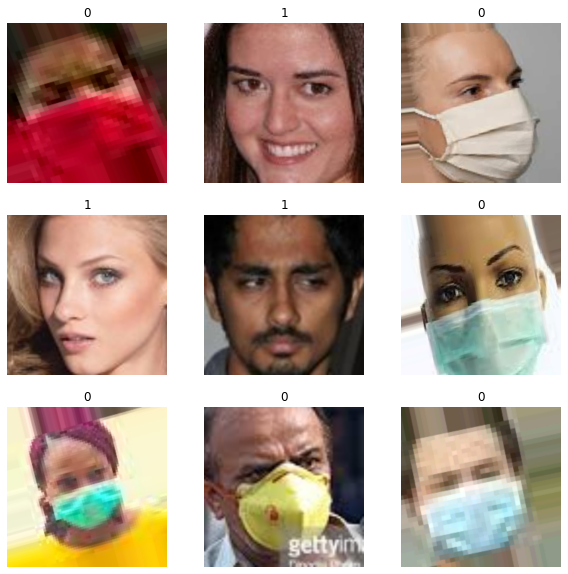

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(labels[i].numpy().astype("uint8"))
        plt.axis("off")

Warstwa Rescale data

In [22]:
from tensorflow.keras import layers
normalize = layers.Rescaling(1./255)

In [23]:
model_simple_sec = tf.keras.Sequential(
    [
        tf.keras.layers.InputLayer(input_shape = (img_height, img_width, img_depth)),
        normalize,
        tf.keras.layers.Conv2D(32, kernel_size=2, activation='relu', 
                           input_shape=(img_width, img_height, img_depth), padding='SAME'),
        tf.keras.layers.MaxPool2D(pool_size=(2,2)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='SAME'),
        tf.keras.layers.MaxPool2D(pool_size=(2,2)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Flatten(),  # spłaszczenie danych do wykorzystania warstwy gęstej
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='softmax')

    ]
)

model_simple_sec.compile(
    # wybór optymalizatora
    optimizer='adam',
    loss='categorical_crossentropy',
    # miara, którą chcemy monitorować
    metrics=['accuracy']
)

model_simple_sec.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 320, 320, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 320, 320, 32)      416       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 160, 160, 32)     0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 160, 160, 32)      0         
                                                                 
 conv2d_5 (Conv2D)           (None, 160, 160, 32)      9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 80, 80, 32)       0         
 2D)                                                  

In [24]:
# Tensorboard i inne callbacki
from datetime import datetime
logdir="logs\\fit\\" + datetime.now().strftime("%Y%m%d-%H%M%S")
best_model_path = "models\\model_" + datetime.now().strftime("%Y%m%d-%H%M%S") + '.h5'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
ms_callback = tf.keras.callbacks.ModelCheckpoint(
    best_model_path,
    monitor="val_loss",
    save_best_only=True,
)



In [25]:
epochs = 1
history = model_simple_sec.fit(
    train_ds,
    epochs = epochs,
    validation_data = val_ds,
    verbose = 1,
    callbacks = [tensorboard_callback, es_callback, ms_callback]
)

 83/313 [======>.......................] - ETA: 12:27 - loss: 0.0000e+00 - accuracy: 0.4959

KeyboardInterrupt: 